# Stop and Frisk in NYC

The New York Police Department publicly releases data concerning its use of "stop & frisk" each year. "Stop & Frisk" is the NYPD's practice of temporarily detaining, questioning, and at times searching civilians on the street for weapons and other contraband. The practice is controversial, as many claim it unfairly targets certain minorities and neighborhoods. For this analysis, I will combine the 2016 NYC Stop and Frisk data with the 2016 Economic Profile of NYC's NTAs. NTAs are Neighborhood Tabulation Areas as created by the NYC Department of City Planning using whole census tracts from the 2010 Census as building blocks. The model I will build will attempt to classify each NTA in 1 of 2 categories, above or below the median number of police stops.

##### Hypothesis:
Areas that NYPD choose to use "Stop & Frisk" most often are ones that are less economically stable. Using economic data concerning the population living in each of NYC's Neighborhood Tabulation Areas, we can determine which neighborhoods of NYC are most targeted for stop and frisk.

###### Data Sources:
Stop and Frisk Data: https://data.cityofnewyork.us/Public-Safety/The-Stop-Question-and-Frisk-Data/ftxv-d5ix

Economic Data: https://data.cityofnewyork.us/City-Government/Demographic-Social-Economic-and-Housing-Profiles-b/kvuc-fg9b

NTA Data (to determine which NTA each police stop was in): https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import itertools
import re
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
%matplotlib inline

In [2]:
plotly.tools.set_credentials_file(username='briansrebrenik', api_key='K6yV5ZOkcoPlllzkQsSb')

In [3]:
police_stops = pd.read_csv('sqf-2016.csv')

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (0,1,2,3,4,8,18,19,73,74,84,85,86,103,110,111) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
police_stops.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM
0,2016,41,22,2072016,100,A,O,P,1,BURG,...,,41,B,2,,1013353,234000,CM,1,14
1,2016,10,22,2182016,30,1,O,P,8,MISDEMEANOR,...,,10,D,,,983478,212373,CM,1,28
2,2016,66,1,1012016,30,1,I,P,2,FEL,...,,66,F,,,988340,172111,CM,1,9
3,2016,47,18,1012016,40,1,O,H,1,FEL,...,,47,C,,,,,CM,1,20
4,2016,79,1,1012016,50,1,O,P,3,D.W.I.,...,,79,G,4,,998197,187413,CM,1,112


In [5]:
police_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12405 entries, 0 to 12404
Columns: 112 entries, year to detailCM
dtypes: object(112)
memory usage: 10.6+ MB


The police data includes addresses for all of the stops. The NTA data gives the shape of each NTA by its coordinates. The function below is used to collect the coordinates of all of the police stops (using Google Maps API) so I can label each stop with the proper NTA.

In [6]:
#API_key = *********
def get_coordinates():
    all_coordinates = []
    for i in tqdm(range(len(police_stops))):
        try:
            sn = police_stops.stname.loc[i]
            si = police_stops.stinter.loc[i]
            cn = police_stops.city.loc[i]
            r = requests.get(
            f'https://maps.googleapis.com/maps/api/geocode/json?address={sn}+and+{si},+{cn},+NY&key={API_key}'
            ).json()
            coordinates = r['results'][0]['geometry']['location']
            all_coordinates.append(coordinates)
        except:
            all_coordinates.append('NA')
    return all_coordinates

In [7]:
# coordinates = get_coordinates()
# police_stops['coordinates'] = coordinates
# police_stops.to_csv('police_stops.csv')

In [8]:
police_stops = pd.read_csv('police_stops.csv')
police_stops.head()

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (1,2,3,4,5,9,19,20,74,75,85,86,87,104,111,112) have mixed types. Specify dtype option on import or set low_memory=False.



,Unnamed: 0,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,...,addrpct,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM,coordinates
0,0,2016,41,22,2072016,100,A,O,P,1,...,41,B,2,,1013353,234000,CM,1,14,"{'lat': 40.81312200000001, 'lng': -73.8942721}"
1,1,2016,10,22,2182016,30,1,O,P,8,...,10,D,,,983478,212373,CM,1,28,"{'lat': 40.7475915, 'lng': -73.9980082}"
2,2,2016,66,1,1012016,30,1,I,P,2,...,66,F,,,988340,172111,CM,1,9,"{'lat': 40.6387311, 'lng': -73.9846689}"
3,3,2016,47,18,1012016,40,1,O,H,1,...,47,C,,,,,CM,1,20,"{'lat': 40.8839888, 'lng': -73.8421695}"
4,4,2016,79,1,1012016,50,1,O,P,3,...,79,G,4,,998197,187413,CM,1,112,"{'lat': 40.6829528, 'lng': -73.93336649999999}"


In [9]:
#loading coordinate info for NTAs
nta = pd.read_csv('nynta.csv')
nta.head()

,the_geom,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-73.94732672160586 40.62916656...,3,Brooklyn,47,BK43,Midwood,27996.591274,3.579964e+07
1,MULTIPOLYGON (((-73.94193078816201 40.70072523...,3,Brooklyn,47,BK75,Bedford,29992.919174,3.262983e+07
2,MULTIPOLYGON (((-73.89138023380268 40.86170058...,2,Bronx,5,BX40,Fordham South,15878.272921,6.307284e+06
3,MULTIPOLYGON (((-73.9760493559142 40.631275905...,3,Brooklyn,47,BK88,Borough Park,39247.227722,5.400502e+07
4,MULTIPOLYGON (((-73.90855790522774 40.65209593...,3,Brooklyn,47,BK96,Rugby-Remsen Village,30957.853395,3.270695e+07


The following steps involve labeling each police report with the proper NTA. Column "the_geom" in the NTA table above contains the shape of each NTA neighborhood. Using the Shapely Python package, I will convert these coordinates into polygon objects. Using this objects, I can determine which NTA's "contain" each police stop.

In [10]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [11]:
shape = []
#using regex to pull coordinates of each NTA
for i in range(len(nta)):
    coord = re.findall('(-?\d\d.\d*\s-?\d\d.\d*)', nta.the_geom.loc[i])
    coord = [x.split() for x in coord]
    coord = [(float(x[0]), float(x[1])) for x in coord]
    shape.append(coord)
#converting each array of coordinates into Polygon object
shape = [Polygon(x) for x in shape]
#dictionary of each NTA and its coordinates
ntas = dict((x[0], x[1]) for x in zip(list(nta.NTAName), shape))

In [12]:
reports_ntas = []
for i in tqdm(range(len(police_stops))):
    try:
        lng = float(re.findall('(-?\d{2}\.\d*)', police_stops.coordinates.loc[i])[1])
        lat = float(re.findall('(-?\d{2}\.\d*)', police_stops.coordinates.loc[i])[0])
        coords = Point(lng, lat)
        find = False
        for x in ntas.keys():
            if ntas[x].contains(coords):
                reports_ntas.append(x)
                find= True
                break
        if not find:
            reports_ntas.append('NA')
    except:
        reports_ntas.append('NA')

100%|██████████| 12405/12405 [00:12<00:00, 967.38it/s] 


In [13]:
police_stops['nta'] = reports_ntas
police_stops.head()

,Unnamed: 0,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,...,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM,coordinates,nta
0,0,2016,41,22,2072016,100,A,O,P,1,...,B,2,,1013353,234000,CM,1,14,"{'lat': 40.81312200000001, 'lng': -73.8942721}",Hunts Point
1,1,2016,10,22,2182016,30,1,O,P,8,...,D,,,983478,212373,CM,1,28,"{'lat': 40.7475915, 'lng': -73.9980082}",Hudson Yards-Chelsea-Flatiron-Union Square
2,2,2016,66,1,1012016,30,1,I,P,2,...,F,,,988340,172111,CM,1,9,"{'lat': 40.6387311, 'lng': -73.9846689}",Borough Park
3,3,2016,47,18,1012016,40,1,O,H,1,...,C,,,,,CM,1,20,"{'lat': 40.8839888, 'lng': -73.8421695}",Eastchester-Edenwald-Baychester
4,4,2016,79,1,1012016,50,1,O,P,3,...,G,4,,998197,187413,CM,1,112,"{'lat': 40.6829528, 'lng': -73.93336649999999}",Crown Heights North


#### Bar Chart of Locations of Stop and Frisk

In [14]:
nta_stop_count = Counter(list(police_stops.nta))
stop_counts = list(nta_stop_count.values())
print(f'Median Stop Count: {np.median(stop_counts)}')
print(f'Mean Stop Count: {np.mean(stop_counts)}')
print(f'Std Stop Count: {np.std(stop_counts)}')
print(f'Min Stop Count: {np.min(stop_counts)}')
print(f'Max Stop Count: {np.max(stop_counts)}')

Median Stop Count: 44.0
Mean Stop Count: 64.94764397905759
Std Stop Count: 64.45939005027392
Min Stop Count: 3
Max Stop Count: 525


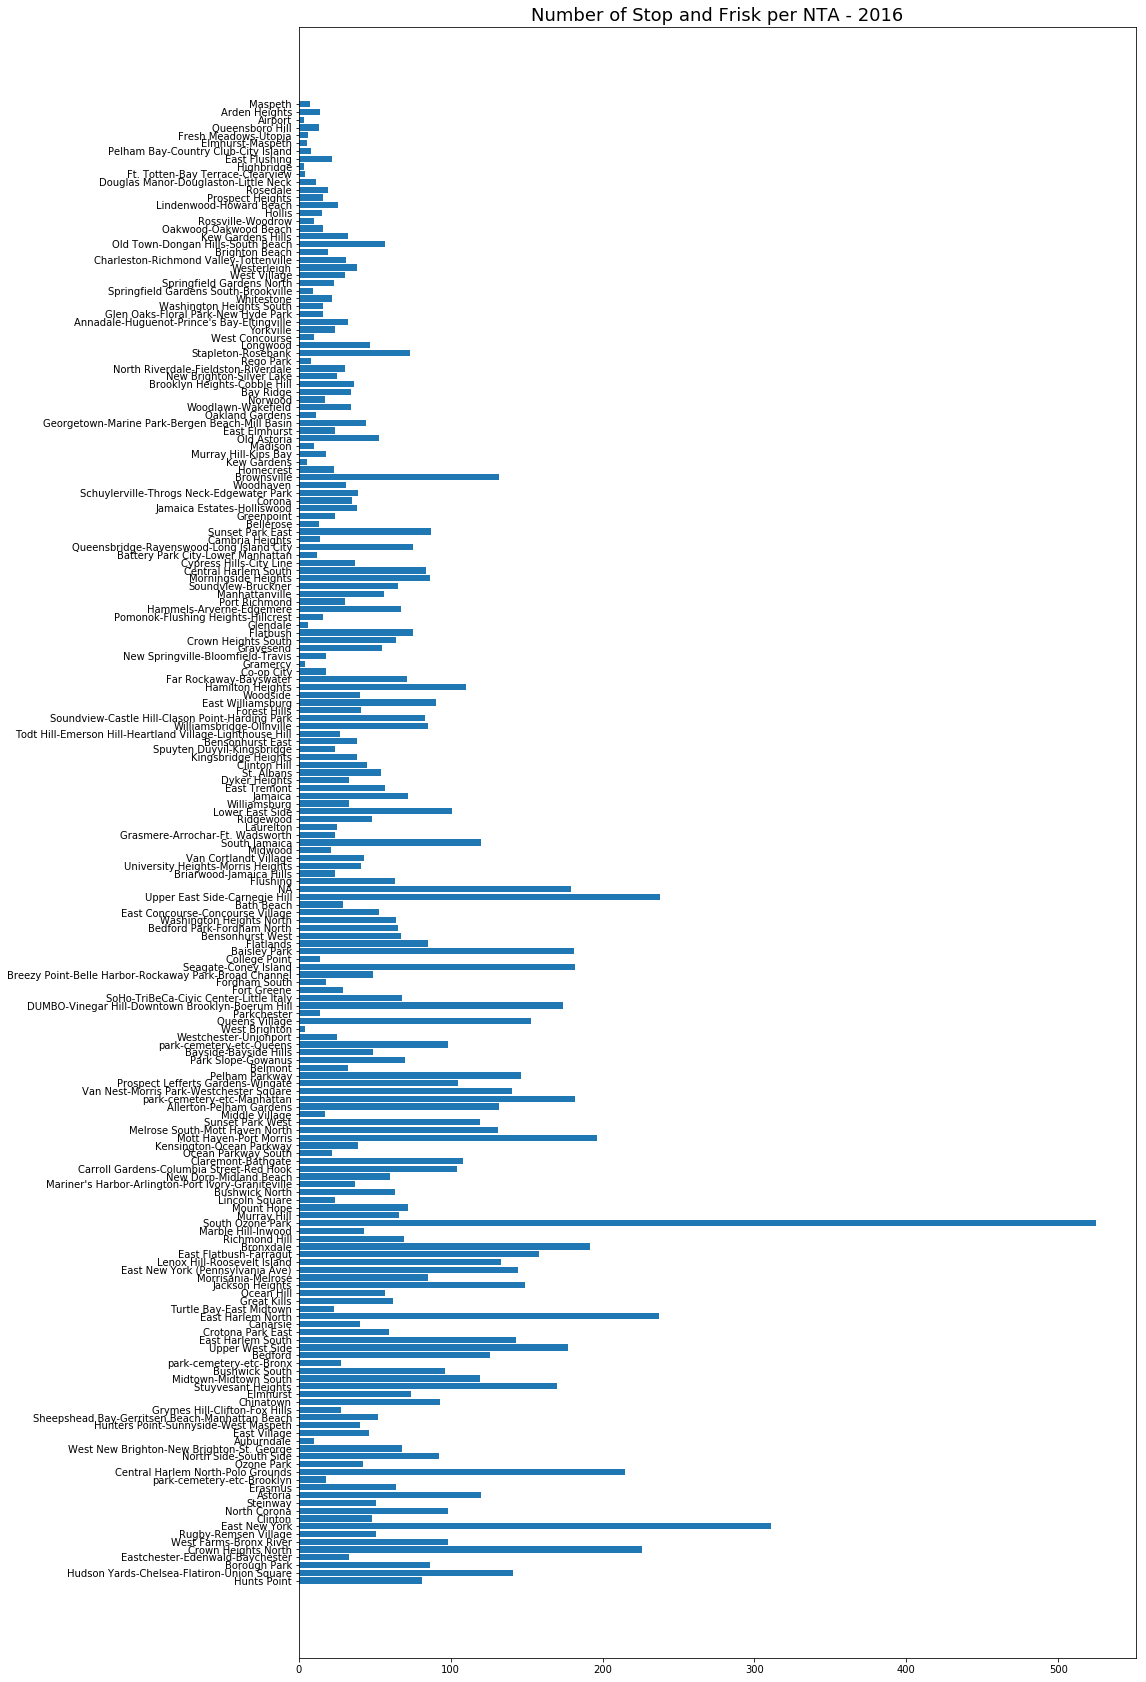

In [15]:
plt.figure(figsize=(15,30))
plt.barh(y=list(nta_stop_count.keys()), width = list(nta_stop_count.values()),)
plt.title('Number of Stop and Frisk per NTA - 2016', size=18)
plt.show()

#### Combining stop and frisk data with econ data

In [16]:
combined_df = nta[['NTAName', 'BoroName']]

In [17]:
combined_df['stop_count'] = np.zeros(len(combined_df))
for i in range(len(combined_df)):
    try:
        stop_count = nta_stop_count[combined_df.NTAName.loc[i]]
        combined_df['stop_count'].loc[i] = stop_count
    except:
        combined_df['stop_count'].loc[i] = None

In [18]:
combined_df.head()

,NTAName,BoroName,stop_count
0,Midwood,Brooklyn,21.0
1,Bedford,Brooklyn,126.0
2,Fordham South,Bronx,18.0
3,Borough Park,Brooklyn,86.0
4,Rugby-Remsen Village,Brooklyn,51.0


In [19]:
econ_stats = pd.read_excel('econ_2016acs5yr_nta.xlsx')

Selecting the following columns from econ data: % of civilian labor force unemployed, % using public transportation to get to work, mean travel time to work,  % employed in service industry, % in management/business industry, % in sales, % in construction, % in production/transportation, median household income, mean household income, % of household with SNAP benefits, % of housholds with cash public assistance income, % with health insurance coverage,  % of families below poverty level.

In [20]:
econ_stats = econ_stats[['GeogName', 'CvLFUEm2P', 'CW_PbTrnsP', 'MnTrvTmE', 'MgBSciArtP', 'SrvcP', 'SalesOffP', 
 'NRCnstMntP', 'PrdTrnsMMP', 'MdHHIncE', 'MnHHIncE', 'Inc_SNAPP', 'Inc_CPbAP', 'HInsP', 'FamBwPvP']]

In [21]:
combined_df = combined_df.set_index('NTAName').join(econ_stats.set_index('GeogName'), how='inner')

In [22]:
combined_df.rename(columns={'CvLFUEm2P': 'percent_unemployed', 'CW_PbTrnsP': 'percent_public_transportation', 
                            'MnTrvTmE': 'mean_travel_time', 'MgBSciArtP': 'percent_business_industry', 
                            'SrvcP': 'percent_service_job', 'SalesOffP': 'percent_sales_job', 
                            'NRCnstMntP': 'percent_construction_job', 'PrdTrnsMMP': 'percent_transportation_job', 
                            'MdHHIncE': 'median_income', 'MnHHIncE': 'mean_income', 
                            'Inc_SNAPP': 'percent_snap', 'Inc_CPbAP': 'percent_pub_assist', 
                            'HInsP': 'percent_with_health_ins', 'FamBwPvP': 'percent_below_pov'}, inplace=True)

In [23]:
combined_df.dropna(inplace=True)

#### Visualizing Econ Data - Distribution of Median Income

In [24]:
x1 = combined_df.median_income[combined_df.BoroName == 'Manhattan']
x2 = combined_df.median_income[combined_df.BoroName == 'Brooklyn']
x3 = combined_df.median_income[combined_df.BoroName == 'Queens']  
x4 = combined_df.median_income[combined_df.BoroName == 'Bronx']
x5 = combined_df.median_income[combined_df.BoroName == 'Staten Island']
# Group data together
hist_data = [x1, x2, x3, x4, x5]

group_labels = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=5000)

# Plot!
py.iplot(fig, filename='Distplot with Multiple Datasets')

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### Feature Engineering

In [25]:
from sklearn.preprocessing import LabelBinarizer, power_transform

In [26]:
#converting boro to categorical
combined_df= pd.get_dummies(combined_df)

In [27]:
combined_df.reset_index(inplace=True)
combined_df.rename(columns= {'index': 'name'}, inplace=True)

In [28]:
combined_df.head()

,name,stop_count,percent_unemployed,percent_public_transportation,mean_travel_time,percent_business_industry,percent_service_job,percent_sales_job,percent_construction_job,percent_transportation_job,...,mean_income,percent_snap,percent_pub_assist,percent_with_health_ins,percent_below_pov,BoroName_Bronx,BoroName_Brooklyn,BoroName_Manhattan,BoroName_Queens,BoroName_Staten Island
0,Midwood,21.0,9.2,47.3,38.2,44.1,18.6,23.8,4.5,8.9,...,77887.0,23.8,2.8,91.4,17.3,0,1,0,0,0
1,Bedford,126.0,12.5,63.7,38.7,41.1,21.6,26.0,4.2,7.2,...,62616.0,35.8,7.3,91.1,30.0,0,1,0,0,0
2,Fordham South,18.0,14.3,66.0,43.0,15.1,46.6,20.2,5.4,12.7,...,37885.0,49.7,12.5,82.3,45.5,1,0,0,0,0
3,Borough Park,86.0,5.7,37.1,34.7,33.7,20.3,30.0,7.6,8.5,...,59062.0,34.9,5.1,91.7,32.7,0,1,0,0,0
4,Rugby-Remsen Village,51.0,9.6,62.4,46.7,27.9,33.0,23.6,8.7,6.8,...,59398.0,20.5,5.0,87.4,16.2,0,1,0,0,0


In [29]:
features = combined_df.drop(columns=['stop_count', 'name'])

#### Labeling NTAs based on whether they fall above or below median number of stops

In [30]:
stop_median = np.median(combined_df.stop_count)

In [31]:
labels = []
for i in range(len(combined_df)):
    if combined_df.stop_count.loc[i] < stop_median:
        labels.append(0)
    else:
        labels.append(1)

In [32]:
combined_df['target'] = labels

#### Correlation Heatmap

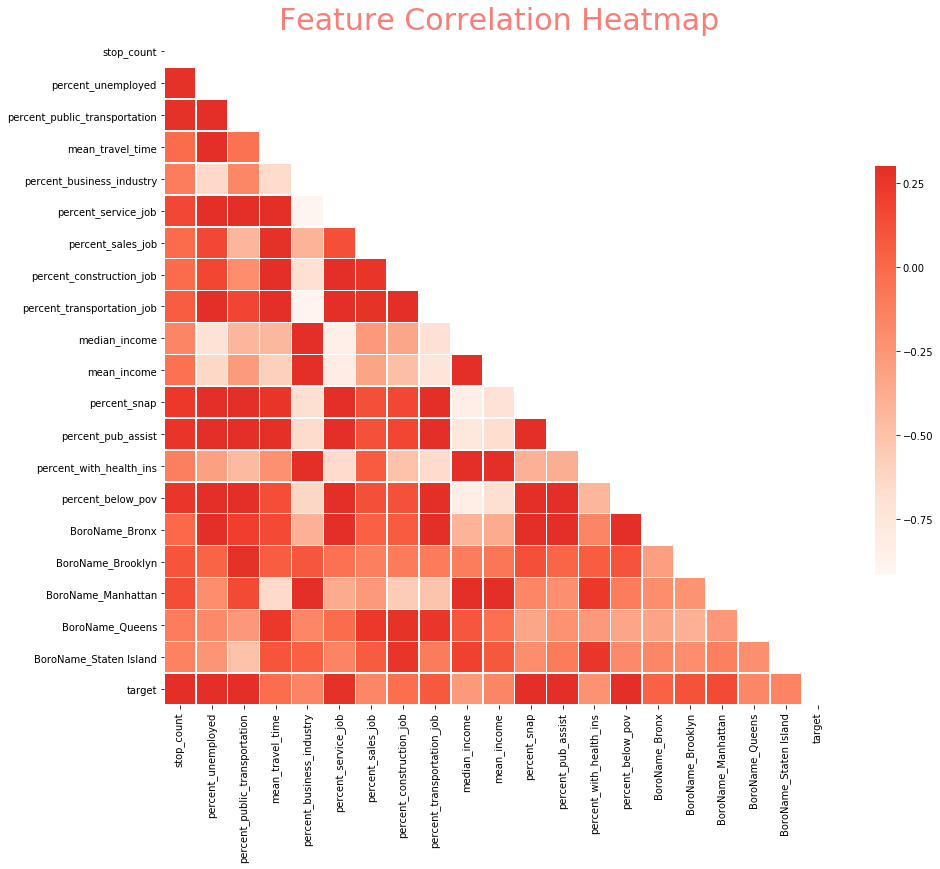

In [33]:
corr = combined_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15))

plt.title("Feature Correlation Heatmap", fontsize = 30, color = "#F97E77")
sns.heatmap(corr, mask=mask, cmap=plt.cm.Reds, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Checking for Multicolinearity and removing excess features

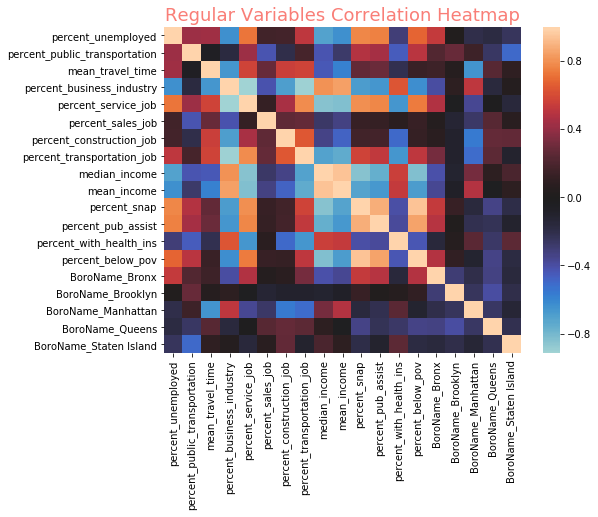

In [34]:
import seaborn as sns
plt.figure(figsize = (8,6))
plt.title("Regular Variables Correlation Heatmap", fontsize = 18, color = "#F97E77")
sns.heatmap(features.corr(), center = 0)

#### Drop "Mean Income" since it has very high corelation with Median Income

In [35]:
features.drop(columns=['mean_income'], inplace=True)

#### encoding classes

In [36]:
lb = LabelBinarizer()
y = lb.fit_transform(combined_df[['target']])

#### Power Transform - transformation applied to make data more Gaussian-like.

In [37]:
features = power_transform(features, method= 'yeo-johnson')

## Building Random Forest Classifier Model
A Random Forest Classifier is a type of ensemble model. It uses a modified tree learning algorithm that inspects, at each split in the learning process, a random subset of the features. The purpose of using an ensemble model is to combine weak models to obtain a high accuracy model.
I chose this ensemble model for two primary reasons:
1: Many of the features are highly correlated, so using many weak models with random selection of variables can help prevent overfitting. 2: Small number of observations and Random Forest uses multiple samples of the dataset, reducing the variance of the final model.

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size= .2, random_state=10)

In [40]:
rfc = RandomForestClassifier(criterion='gini', n_estimators=120)

In [41]:
rfc.fit(X_train, y_train)

/Users/briansrebrenik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Model Evaluation

For my model, I decided to use two different metrics, a confusion matrix and area under the curve.

The confusion matrix is a table that summarizes how successful the classification model is at predicting examples for 
the two classes. In my confusion matrix below, the table is split into 4 quadrants representing True Positive, True Negative, False Positive and False Negative. From these numbers, we can calculate common classification metrics like accuracy and recall. For example, accuracy = TP + TN / TP + TN + FP + FN and recall = TP/ TP + FN. For this model, recall is especially important because we want to find those areas where stop and frisk happens more than the median (TP).

Area under the ROC Curve uses a combination of True Positive Rate and False Positive Rate to summarize how well the model performs. The greater the AUC, the better the model

In [42]:
preds = rfc.predict(X_test)

#### Recall

In [43]:
print(f'model recall score: {recall_score(y_test, preds)}')

model recall score: 0.6


#### Accuracy

In [44]:
print(f'model accuracy score: {accuracy_score(y_test, preds)}')

model accuracy score: 0.631578947368421


#### Confusion Matrix

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[12  6]
 [ 8 12]]


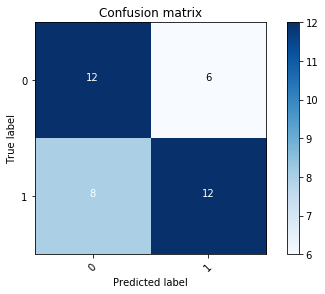

In [46]:
plot_confusion_matrix(confusion_matrix(y_test, rfc.predict(X_test)), classes=[0,1])

#### ROC Curve

AUC: 0.6333333333333334


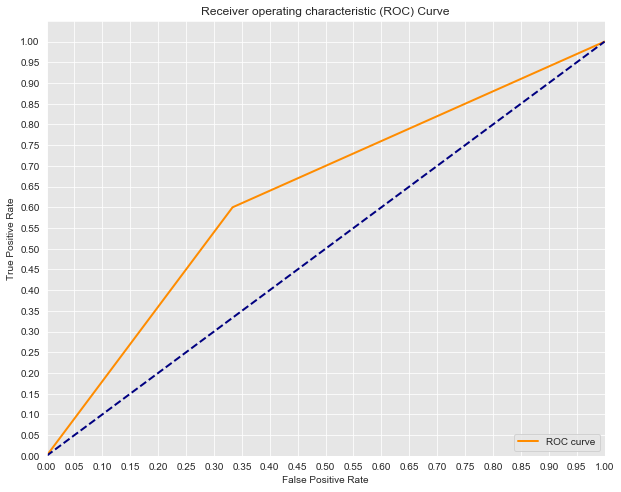

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict(X_test))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Analysis

Based on the results of the model, it is clear that there is a correlation between the economic health of NYC neighborhoods and the amount of stop and frisk occurences in those neighborhoods. Certain economic features such as unemployment rate and percentage of households receiving SNAP benefits show a fair degree of correlation with number of police stops. However, the models recall score of .65 tells me that it finds it more difficult to find the true positives. One might infer from this that while poor economic environment does lead to increases in stop and frisk, there are neighborhoods with better economic statistics that also have higher number of stop and frisks. Further analysis would require looking into other factors including demographics and number of people who work in an NTA as opposed to living there.